#  TBATS - Prophet - Hybrid MODEL

## TBATS
TBATS models a time series \(y_t\) as:
$$
y_t = \lambda_t + d_t + \sum_{i=1}^{K} s_{i,t} + \varepsilon_t
$$

Each seasonal component is represented with trigonometric (Fourier) terms:
$$
s_{i,t} \;=\; \sum_{j=1}^{m_i} \left( a_{i,j}\cos\left(\frac{2\pi j t}{m_i}\right) \;+\; b_{i,j}\sin\left(\frac{2\pi j t}{m_i}\right) \right)
$$
where \(m_i\) is the period for seasonal component \(i\).


## Prophet
Prophet decomposes the series as:
$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

Seasonality in Prophet (Fourier series) is:
$$
s(t) = \sum_{n=1}^{N} \left( a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right)
$$
with \(P\) the seasonal period (e.g., 365.25 for yearly).

## Hybrid (TBATS + Prophet)
The hybrid forecast used in your notebook is the simple elementwise average:
$$
\hat{y}^{\text{Hybrid}}_t \;=\; \frac{\hat{y}^{\text{TBATS}}_t \;+\; \hat{y}^{\text{Prophet}}_t}{2}
$$




# 📦 Library Imports Overview

- **pandas**: Used for data input/output (IO) and manipulation tasks such as reading CSV files, handling time series data, and processing DataFrames.

- **darts.TimeSeries**: Provides a convenient time series data structure used throughout the Darts forecasting library.

- **darts.models.TBATS & Prophet**:  
  - **TBATS**: A forecasting model well-suited for time series with multiple seasonalities.  
  - **Prophet**: A forecasting model developed by Facebook, designed for interpretable time series forecasting.

- **darts.metrics.smape & mse**: Evaluation metrics to measure forecast accuracy.  
  - `smape`: Symmetric Mean Absolute Percentage Error.  
  - `mse`: Mean Squared Error.

- **matplotlib.pyplot**: A plotting library for creating visualizations of time series data and forecast results.


In [19]:
import pandas as pd
from darts import TimeSeries
from darts.models import TBATS, Prophet
from darts.metrics import smape, mse
import matplotlib.pyplot as plt

# 🔧 Configuration Parameters

- **CSV_PATH**: Path to the CSV file that must contain a date column named `datum` and columns with the names listed in `CATEGORIES`.

- **CATEGORIES**: A list of column names in the CSV to be forecasted (the script runs one loop iteration per category).

- **FORECAST_STEPS**: Number of time steps (days) to predict ahead.

- **EMA_SPAN**: Smoothing window parameter used for the Exponential Moving Average (EMA) smoother.


In [20]:
CSV_PATH = r"D:\HACH_cts\dataset\salesweekly.csv"  # <<-- your file
CATEGORIES = ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]
FORECAST_STEPS = 30            # days ahead
EMA_SPAN = 7 

# PROPHET PARAMETERS

In [21]:
PROPHET_PARAMS = {
    "M01AB": {"changepoint_prior_scale": 30,   "interval_width": 0.0005},
    "M01AE": {"changepoint_prior_scale": 0.05, "interval_width": 0.0005},
    "N02BA": {"changepoint_prior_scale": 0.005,"interval_width": 0.0005},
    "N02BE": {"changepoint_prior_scale": 10,   "seasonality_prior_scale": 170, "interval_width": 0.0005},
    "N05B":  {"changepoint_prior_scale": 5,    "interval_width": 0.0005},
    "N05C":  {"changepoint_prior_scale": 0.5,  "interval_width": 0.005},
    "R03":   {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 160, "interval_width": 0.0005},
    "R06":   {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 120, "interval_width": 0.0005},
}

# Utility functions

In [22]:
def infer_season_length_from_index(index) -> int:
    try:
        freq = pd.infer_freq(index)
    except Exception:
        freq = None

    if freq is None:
        return 7
    if freq.startswith("D"):
        return 7
    if freq.startswith("M"):
        return 12
    return 7

def ema_smooth(s: pd.Series, span: int = EMA_SPAN) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def plot_forecast(series_smooth_ts, forecast, cat, steps=30):
    plt.figure(figsize=(12, 6))
    plt.plot(series_smooth_ts.time_index, series_smooth_ts.values(),
             label=f"{cat} Actual (smoothed)", color="blue")
    forecast_index = forecast.time_index
    plt.plot(forecast_index, forecast.values(),
             'o-', color='orange', label=f"{cat} {steps}-step Forecast")
    plt.legend()
    plt.title(f"{cat} Forecast Visualization")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Read the CSV and set up the index

In [23]:
df = pd.read_csv(CSV_PATH, parse_dates=["datum"])
df.set_index("datum", inplace=True)
df = df.asfreq("D")

# 🔮 Hybrid Forecasting Process

- **Smooths raw series with EMA**: Applies Exponential Moving Average to smooth the raw time series data.

- **Converts to Darts TimeSeries**: Transforms the smoothed Pandas Series into a Darts `TimeSeries` object for modeling.

- **Train/Validation Split**: Splits the data into a training set and a validation set, using the last `steps` points as validation.

- **TBATS Model**: Infers season length, fits a TBATS model on the training data, and predicts `steps` ahead.

- **Prophet Model**: Initializes a Prophet model (with category-specific parameters), fits it on the training data, and predicts `steps` ahead.

- **Hybrid Forecast**: Combines TBATS and Prophet predictions by averaging them elementwise.

- **Returns**:  
  - `hybrid`: The hybrid forecast (`TimeSeries`)  
  - `tbats_f`: TBATS forecast (`TimeSeries`)  
  - `prophet_f`: Prophet forecast (`TimeSeries`)  
  - `series`, `train`, `val`: The full smoothed series, training set, and validation set.


In [24]:
def hybrid_forecast_ema(series_raw: pd.Series, cat: str, steps: int = 30):
    series_raw = series_raw.fillna(0)
    series_smooth = ema_smooth(series_raw, EMA_SPAN)
    series = TimeSeries.from_series(series_smooth)
    train, val = series[:-steps], series[-steps:]

    season_len = infer_season_length_from_index(series.time_index)
    tbats = TBATS(season_length=season_len)
    tbats.fit(train)
    tbats_f = tbats.predict(steps)

    p_params = PROPHET_PARAMS.get(cat, {})
    prophet = Prophet(**p_params)
    prophet.fit(train)
    prophet_f = prophet.predict(steps)

    hybrid = (tbats_f + prophet_f) / 2
    return hybrid, tbats_f, prophet_f, series, train, val

# 🔁 Main Forecasting Loop

- **Iterates over each category/column**: Loops through all specified categories in the dataset.

- **Calls the hybrid forecasting function**: Runs the `hybrid_forecast_ema` function to generate forecasts and trained models.

- **Stores forecasts**: Converts the hybrid forecast to a Pandas Series and stores it in `all_forecasts`.

- **Computes metrics**: Calculates `MSE` and `sMAPE` for TBATS, Prophet, and the hybrid forecast using `darts.metrics`.

- **Appends metrics**: Adds a row of calculated metrics to the `metrics` list.

- **Plots forecasts**: Generates and displays an interactive plot of actual vs. forecasted data for each category.

- **Writes output files**:
  - `hybrid_forecasts_ema.csv`: Contains forecast values for each category, indexed by forecast datetimes.
  - `forecast_metrics_ema.csv`: Contains a metrics table with `MSE` and `sMAPE` for each category and model.


19:11:08 - cmdstanpy - INFO - Chain [1] start processing
19:11:08 - cmdstanpy - INFO - Chain [1] done processing


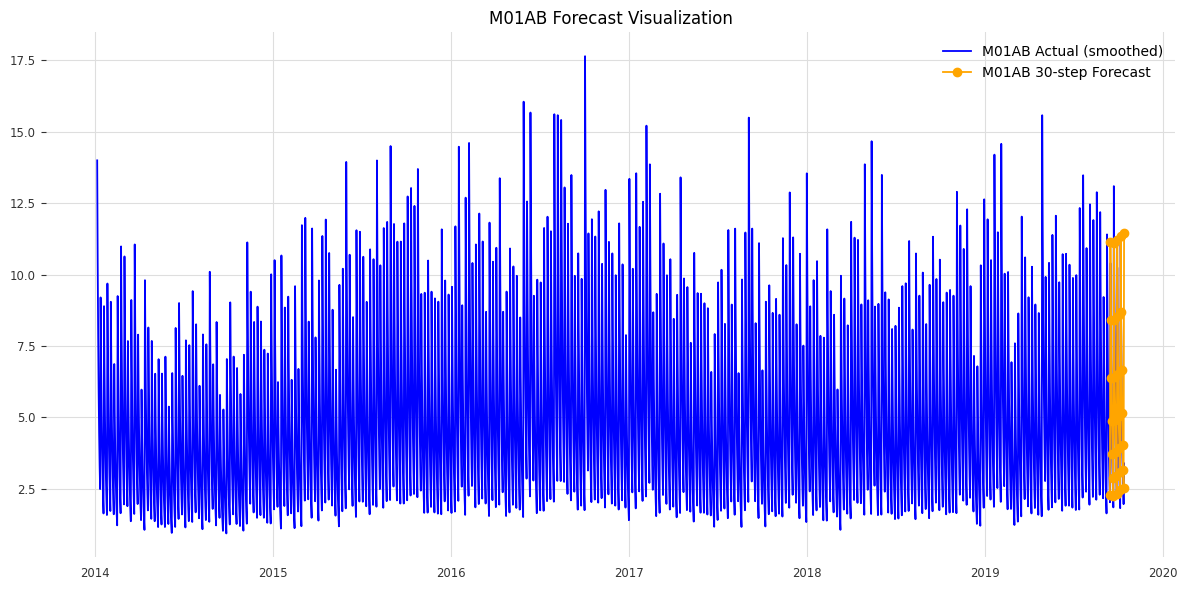

19:11:09 - cmdstanpy - INFO - Chain [1] start processing
19:11:09 - cmdstanpy - INFO - Chain [1] done processing


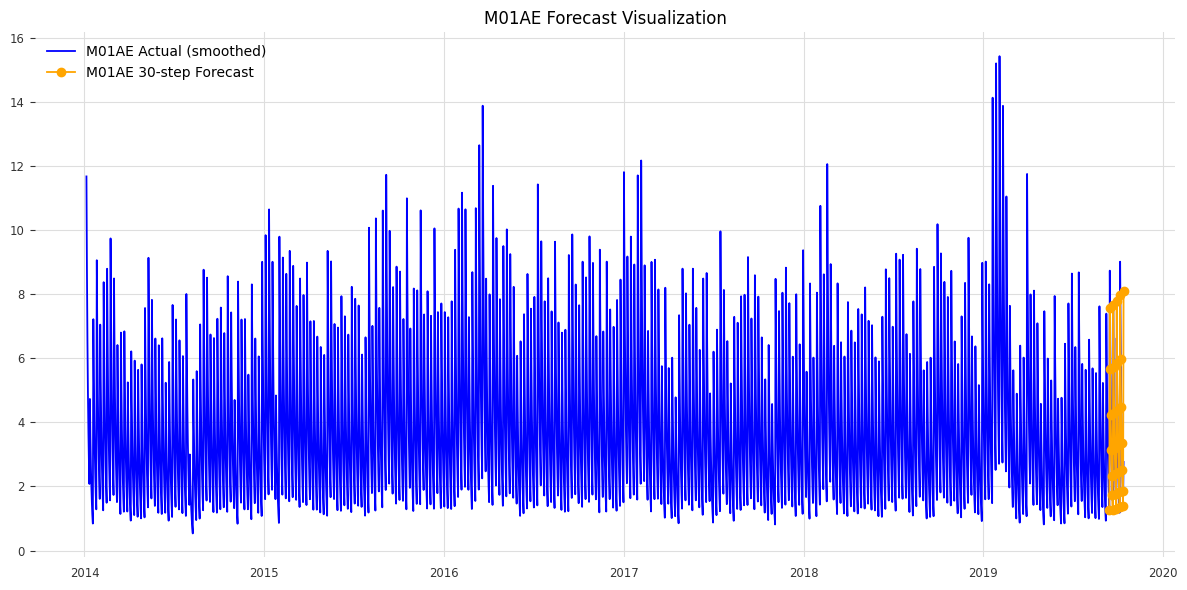

19:11:10 - cmdstanpy - INFO - Chain [1] start processing
19:11:10 - cmdstanpy - INFO - Chain [1] done processing


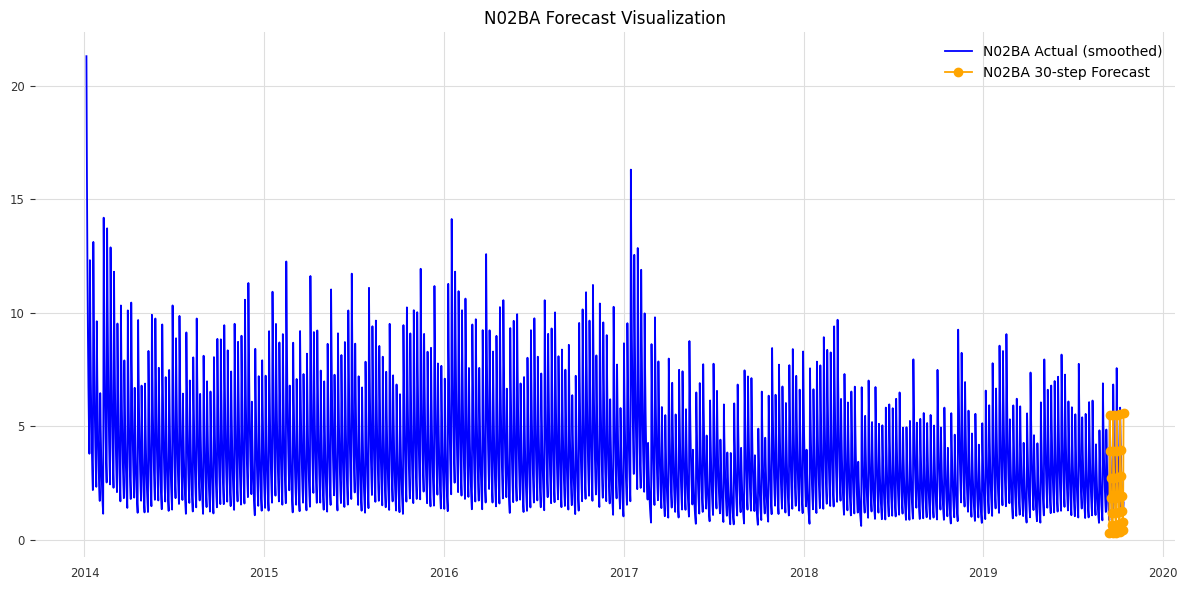

19:11:10 - cmdstanpy - INFO - Chain [1] start processing
19:11:11 - cmdstanpy - INFO - Chain [1] done processing


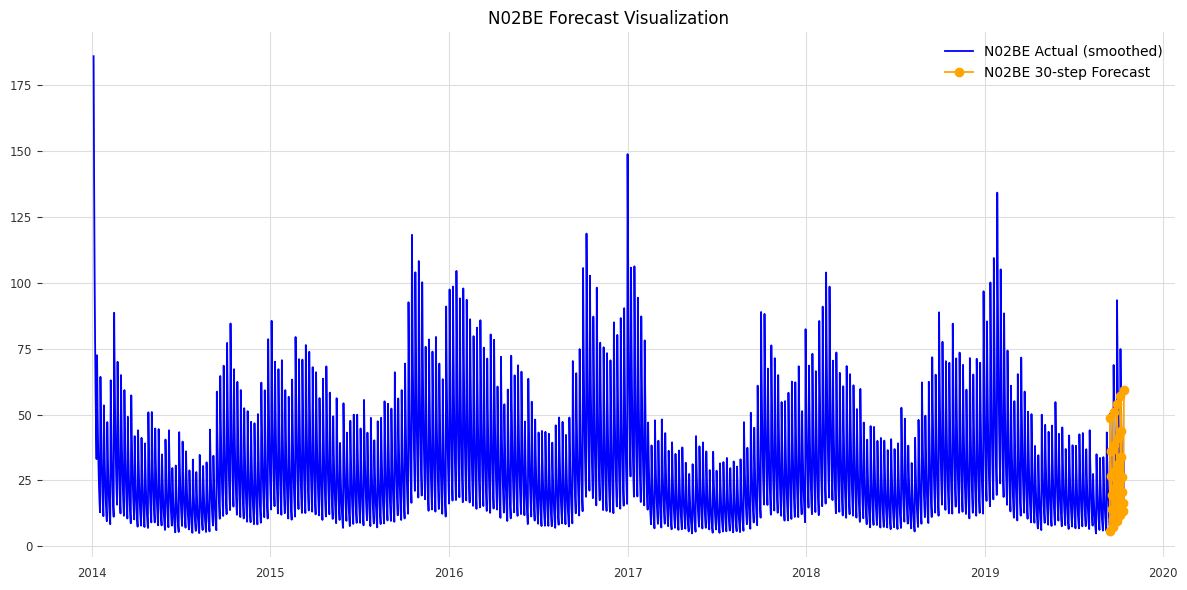

19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:12 - cmdstanpy - INFO - Chain [1] done processing


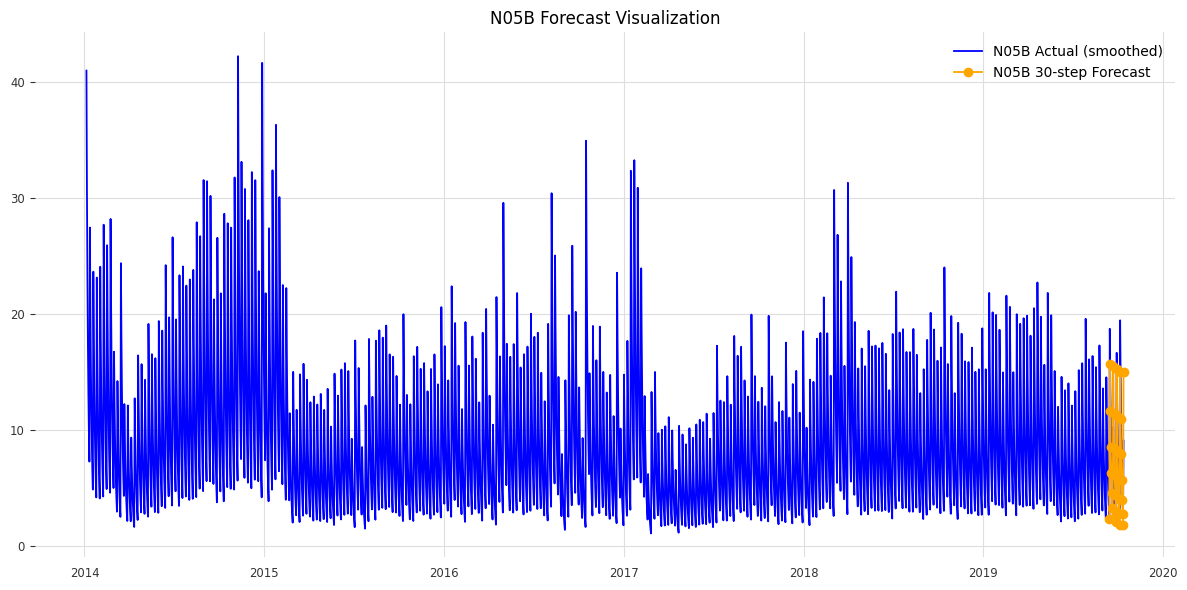

d:\HACH_cts\.venv\Lib\site-packages\statsforecast\tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing


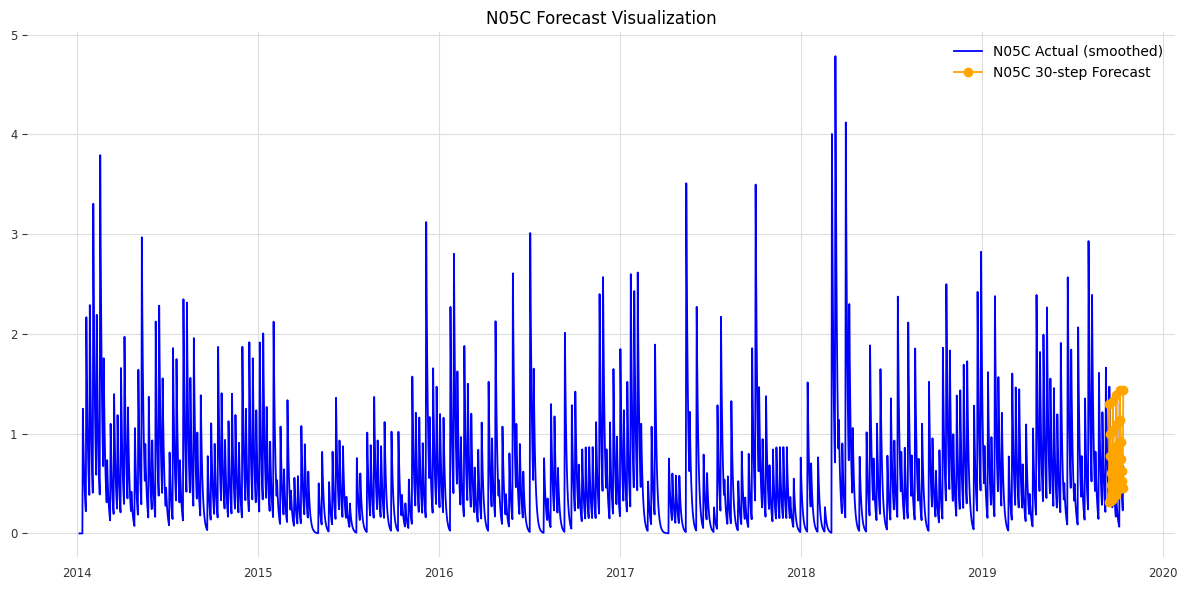

19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing


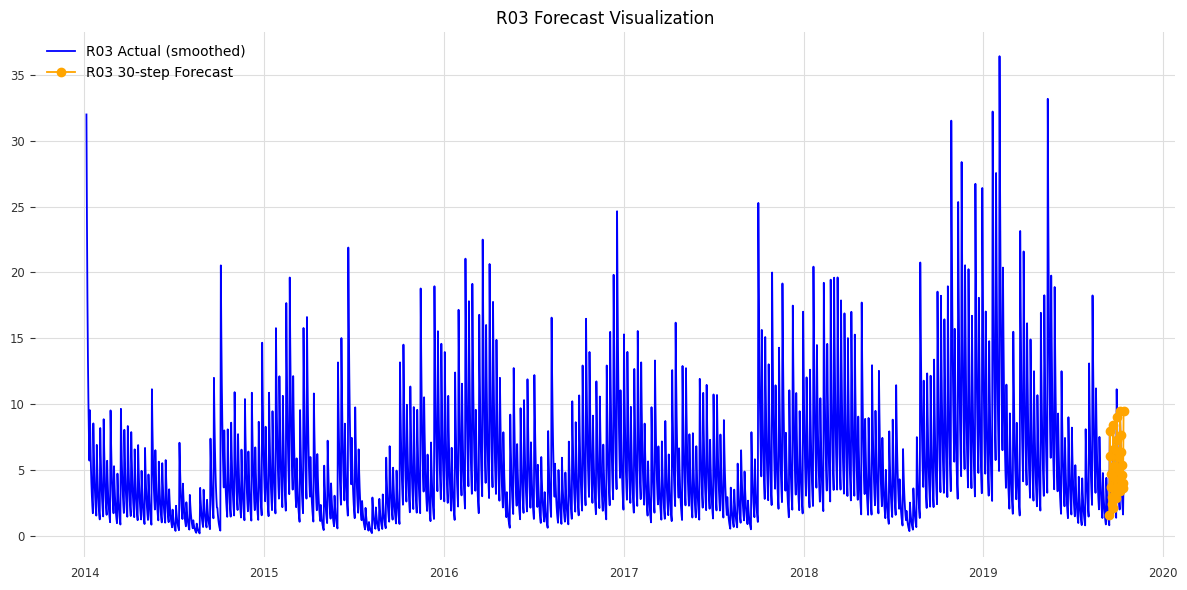

19:11:14 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing


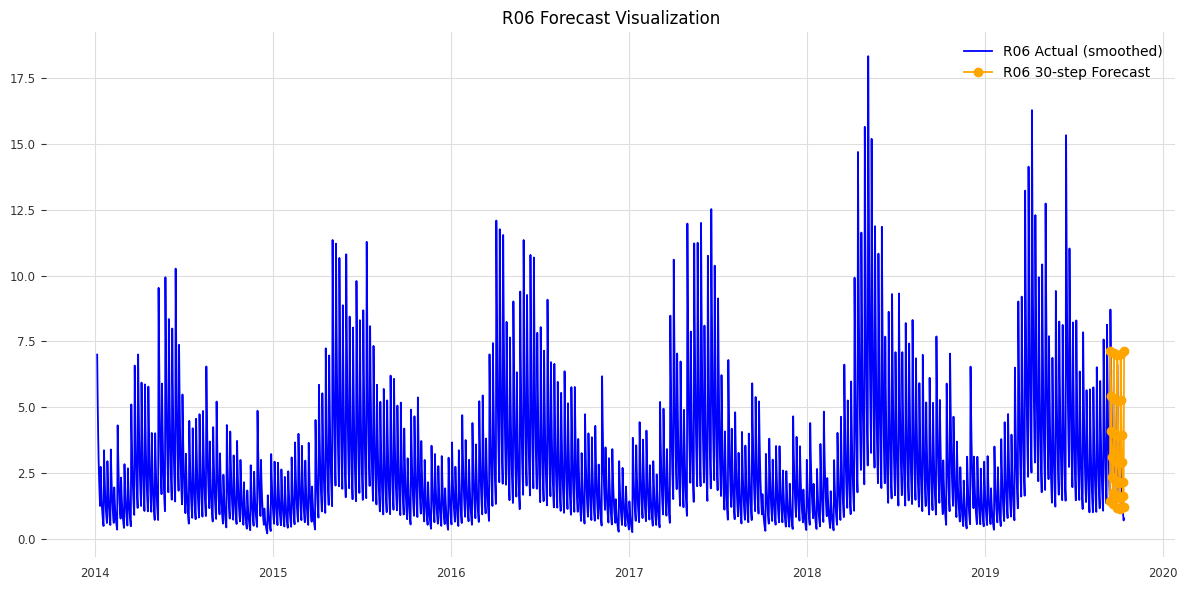


Saved EMA Hybrid forecasts to: hybrid_forecasts_ema.csv
                M01AB     M01AE     N02BA      N02BE       N05B      N05C  \
datum                                                                       
2019-09-14   2.275048  1.268535  0.290579   5.745603   2.359522  0.310878   
2019-09-15  11.127918  7.558127  5.516990  48.694500  15.688463  1.297141   
2019-09-16   8.426268  5.655378  3.924934  35.996311  11.639300  0.998713   
2019-09-17   6.397961  4.222802  2.730725  26.509207   8.598714  0.776058   
2019-09-18   4.875613  3.144176  1.835030  19.440236   6.313739  0.610500   

                 R03       R06  
datum                           
2019-09-14  1.532336  1.451785  
2019-09-15  7.936960  7.142298  
2019-09-16  6.060226  5.408841  
2019-09-17  4.679328  4.093142  
2019-09-18  3.670700  3.092045  

Saved metrics to: forecast_metrics_ema.csv
  Category   TBATS_MSE  TBATS_SMAPE  Prophet_MSE  Prophet_SMAPE  Hybrid_MSE  \
0    M01AB    2.600784    12.526377     2.833149 

In [25]:
all_forecasts = {}
metrics = []

for cat in CATEGORIES:
    series_raw = df[cat]
    hybrid, tbats_f, prophet_f, series_smooth_ts, train, val = hybrid_forecast_ema(series_raw, cat, FORECAST_STEPS)

    all_forecasts[cat] = hybrid.to_series()

    tbats_mse = mse(val, tbats_f)
    tbats_smape = smape(val, tbats_f)
    prophet_mse = mse(val, prophet_f)
    prophet_smape = smape(val, prophet_f)
    hybrid_mse = mse(val, hybrid)
    hybrid_smape = smape(val, hybrid)

    metrics.append({
        "Category": cat,
        "TBATS_MSE": tbats_mse, "TBATS_SMAPE": tbats_smape,
        "Prophet_MSE": prophet_mse, "Prophet_SMAPE": prophet_smape,
        "Hybrid_MSE": hybrid_mse, "Hybrid_SMAPE": hybrid_smape
    })

    # Plot the forecasts in your desired style
    plot_forecast(series_smooth_ts, hybrid, cat, FORECAST_STEPS)

forecast_df = pd.DataFrame(all_forecasts)
forecast_df.to_csv("hybrid_forecasts_ema.csv")
print("\nSaved EMA Hybrid forecasts to: hybrid_forecasts_ema.csv")
print(forecast_df.head())

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("forecast_metrics_ema.csv", index=False)
print("\nSaved metrics to: forecast_metrics_ema.csv")
print(metrics_df)

# 📊 Forecasting Metrics Conclusion

The forecasting results compare **TBATS**, **Prophet**, and a **Hybrid (average)** model across all categories.  

### Key Observations:
- **Hybrid Performance**:  
  - The hybrid approach often provides a balance between TBATS and Prophet forecasts, leading to more stable results.  
  - In some categories (e.g., `R03`), the hybrid model achieves a **much lower MSE** compared to both TBATS and Prophet individually, showing strong ensemble benefits.

- **TBATS Strengths**:  
  - TBATS performs well in categories like `M01AB`, `M01AE`, and `N05C`, with relatively low MSE and SMAPE.  
  - It is particularly effective for datasets with complex seasonality patterns.

- **Prophet Insights**:  
  - Prophet shows higher SMAPE in several categories (e.g., `N02BA`, `N05C`), indicating less accurate percentage-based predictions.  
  - However, it performs competitively in `R06` with the lowest MSE.

### Overall Conclusion:
- The **Hybrid Model** generally outperforms or matches individual models, making it a **robust choice for diverse time series**.  
- TBATS is strong for **seasonal data**, while Prophet may require **further parameter tuning** to handle irregularities better.  


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Example: replace with your actual variable names ---
actual = df['M01AB'][-len(forecast):]   # actual values for same period
forecast = forecast_df['M01AB']               # forecasted values

# Visualize comparison
plt.figure(figsize=(12,6))
plt.plot(actual.index, actual.values, label="Actual", marker='o')
plt.plot(forecast.index, forecast.values, label="Forecast", marker='x')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs Forecast")
plt.legend()
plt.show()

# --- Metrics ---
mse = mean_squared_error(actual, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast)
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


NameError: name 'forecast' is not defined